Auteur : HACHEMIN Pierre-Yves et SEYS Thibaut

Date : 25/04/2018

Cours : IS3024AB - Data Mining

# Etude sur le transport en Ile-de-France

* [Introduction](#Introduction)

    + [Contexte et objectifs](#Contexte-et-objectifs)
    
    + [Requirements](#Requirements)

* [Datasets](#Datasets)

    + [Description des datasets](#Description-des-datasets)
    
    + [Composition des datatsets](#Composition-des-datasets)
    
* [Traitements des datasets](#Traitements-des-datasets)

    + [Datasets de validation](#Datasets-de-validation)
    
    + [Traitements sur le pourcentage de validation](#Traitements-sur-le-pourcentage-de-validation)
    
    + [Traitements sur le nombre de validation](#Traitements-sur-le-nombre-de-validation)
    
    + [Emplacements des stations](#Emplacements-des-stations)
    
    + [Obtention du dataset final](#Obtention-du-dataset-final)
    
    + [Visualisation du dataset](#Visualisation-du-dataset)

* [Analyse du dataset final](#Analyse-du-dataset-final)

    + [Diminution de la dimension](#Diminution-de-la-dimension)
    
    + [Choix des grandeurs](#Choix-des-grandeurs)
    
    + [Clustering](#Clustering)
    
* [Conclusion et visualisation finale](#Conclusion-et-visualisation-finale)

    + [Visualisation](#Visualisation)
    
    + [Conclusion](#Conclusion)

## Introduction

### Contexte et objectifs

Pour notre projet de Data Mining, nous avons choisi d'explorer les données issues de la palteforme Open Data du Syndicat des Transports d'Ile-de-France (STIF) disponible à [cette adresse](https://opendata.stif.info/). Nous avons décidé d'explorer les données issues de la validation des voyageurs sur les différents réseaux ferrés d'Ile-de-France.

Notre objectif est de mener étude sur les caractéristiques actuelles du réseau ferré. Nous allons donc appliquer des algorithmes de clustering sur les différentes stations du réseau afin de mettre en évidence les profils types.

### Requirements

Pour que notre projet fonctionne correctement, nous avons besoin d'importer les libraries suivantes :

In [30]:
%matplotlib inline
import csv

import folium # version 0.2.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch # Algo that need n_clusters

## Datasets

### Description des datasets

Parmis les jeux de données mis à disposition par la plateforme Open Data du STIF, nous avons choisi d'utiliser les 4 types de datasets suivants :

- [validations-nombre-par-jour-2017s1](https://opendata.stif.info/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/) et [validations-nombre-par-jour-2017s2](https://opendata.stif.info/explore/dataset/validations-sur-le-reseau-ferre-profils-horaires-par-jour-type-2e-sem/) : contiennent le nombre de validations par jour par station par catégorie de titre de transport pour chaqeu semestre de 2017.

- [validations-profils-horaires-2017s1](https://opendata.stif.info/explore/dataset/validations-sur-le-reseau-ferre-profils-horaires-par-jour-type-1er-sem/) et [validations-profils-horaires-2017s2](https://opendata.stif.info/explore/dataset/validations-sur-le-reseau-ferre-profils-horaires-par-jour-type-2e-sem/) : contiennent les pourcentages moyens de validation par tranche horaire à la station donnée suivant le type de journée (jour ordinaire, dimanche, etc...)  pour chaque semestre de 2017.

- [emplacement-des-gares-idf](https://opendata.stif.info/explore/dataset/emplacement-des-gares-idf/) : contient les emplacements de l'ensemble des stations du réseau ferré d'Ile-de-France.

- [referentiel-arret-tc-idf-](https://opendata.stif.info/explore/dataset/referentiel-arret-tc-idf/) : recense l'ensemble des stations des réseaux de surface et ferré de transport d'Ile-de-France suivant différents niveaux de granularités.

Tous ces datasets sont disponibles dans le dossier `Data` sous forme de fichiers csv.

### Composition des datasets

Nous allons décrire dans cette partie les différents champs que nous allons utiliser pour chaque type de datasets que nous utilisons. De la documentation plus précise émise par le STIF se trouve dans le dossier `doc` sous forme de fichiers PDF.

#### **Datasets du nombre de validations par jour**

Les champs que nous avons choisi de garder sont représentés dans le tableau suivant :

| Nom du champs | Description | Valeur |
|---------------|-------------|--------|
| LIBELLE_ARRET | Libellée de l'arrêt | string |
| ID_REFA_LDA | Id de l'arrêt | float |
| JOUR | Jour de l'année | string |
| CATEGORIE_TITRE | Catégorie du titre | AMETHYSTE, AUTRE TITRE, FGT, IMAGINE R, NAVIGO, TST |
| NB_VALD | Nombre de validations | int ou 'Moins de 5' |

#### **Datasets du profil de validation**

Les champs que nous avons choisi de garder sont représentés dans le tableau suivant :

| Nom du champs | Description | Valeur |
|---------------|-------------|--------|
| LIBELLE_ARRET | Libellée de l'arrêt | string |
| ID_REFA_LDA | Id de l'arrêt | float |
| CAT_JOUR | Type de journée | JOHV, SAHV, JOVS, SAVS, DIJFP |
| TRNC_HORR_60 | Tranche horaire | Interval (ex: 13H - 14H) |
| pourc_validations | Pourcentage de validations | float |

#### **Datasets du référentiels des stations du réseau**

La modélisation d'un arrêt est une chose compliquée et le STIF possède trois niveaux de détails décrit ci-après du niveau le plus large au moins large :

1. LDA : le premier niveau concerne l'ensemble des arrêts du même nom. Par exemple, pour l'arrêt 'République' il y a à la fois les différentes lignes de métro et les arrêts de bus.

2. ZDL : le second niveau décrit l'ensemble des arrêts d'un même mode de transport. En reprenant l'exemple de l'arrêt 'République', on aura une ZDL pour le métro et une autre pour les arrêts de bus.

3. ZDE : le dernier niveau décrit une zone d'embarquement. C'est l'endroit où l'usager peut physiquement emprunter la ligne de transport. Dans le cas de la ZDL des métro à 'République', il y aura une ZDE par ligne de métro.

Ce dataset nous permet de faire les liens entre les stations des datasets de validation qui contiennet l'id de la LDA et le dataset des emplacements des stations qui contiennent les id de ZDE et ZDL. Voici les champs que nous allons utiliser au cours de notre traitement de données :

| Nom du champs | Description | Valeur |
|---------------|-------------|--------|
| ZDEr_LIBELLE_TYPE_ARRET | Libellée du type d'arrêt | Arrêt de bus, Station ferrée / Val, Arrêt de tram, Station de métro, Station de funiculaire |
| LDA_ID_REF_A | Id de la LDA | float |
| ZDLr_ID_REF_A | Id de la ZDL | float |
| ZDEr_ID_REF_A | Id de la ZDE | float |

#### **Datasets des emplacements des stations du réseau ferré**

Ce dataset va nous permettre de relier les données des datasets de validations à des positions géographiques et aux lignes du réseau ferré passant par ces stations. Les champs dont nous allons avoir besoin sont décrits dans le tableau suivant :

| Nom du champs | Description | Valeur |
|---------------|-------------|--------|
| Geo Point | Coordonnées de la station | tuple |
| LIGNES | Ligne passant par cette station | string |
| ID_REF_ZDL | Id de la ZDL | float |
| ID_REF_ZDE | Id de la ZDE | float |

## Traitements des datasets

L'objectif de cette partie est d'arriver à un unique dataset sur lequel on effectuera nos calculs. Pour cela nous allons partir du dataset du nombre de validation par jour par station et le transformer pour avoir comme colonne : 

- JOUR : date du jour

- LIBELLE_ARRET : Libellée de l'arrêt

- ID_REFA_LDA : ID LDA de l'arrêt

- LIGNES : Lignes passant par cette station

- CAT_JOUR : Catégorie du jour parmi JOHV, SAHV, JOVS, SAVS et DIJFP

- COORDINATE_X : Longitude de la station

- COORDINATE_Y : Latitude de la station

- TRANCHE_HORRAIRE (x24) : Une colonne par pourcentage de validation de la tranche horaire

- NB_VALIDATION (x6) : Une colonne par titre de transport contenant le nombre de validation

On arrivera donc à 37 colonnes par station par jour de l'année 2017.

### Datasets de validation

Pour commencer nous allons charger les datasets du nombre de valdiation et des profiles horaires. Pour les datasets de profils horaires, le STIF nous fournit une ligne par arrêt par catégorie de jour par tranche horraire. Or, nous souhaitons obtenir une ligne par arrêt et par catégorie de jour, les pourcentages suivants la tranche horaire étant contenus dans une colonne par tranche. Pour le dataset du nombre de validation par jour, nous avons exactement le même problème avec les catégories de titres de transport. Nous allons donc effectuer cette transformation au moment où nous chargeons les données dans des DataFrames pandas.

In [31]:
# Fonction générique permettant le chargement des csv de validations
def load_csv(csv_filename, columns, to_flatten, value):
    with open(csv_filename, 'r', newline='\n') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        
        data = {}
        header = {elt: index for index, elt in enumerate(next(csv_reader))}
        flattens = set()
        
        for row in csv_reader:
            key = tuple(row[header[column]] for column in columns)
            flattens.add(row[header[to_flatten]])
            try:
                data[key][row[header[to_flatten]]] = row[header[value]]
            except KeyError:
                data[key] = {row[header[to_flatten]]: row[header[value]]}
                
        df_dict = {elt:  [] for elt in columns}
        df_dict.update({elt: [] for elt in flattens})
    
        for key, values in data.items():
            for index, column in enumerate(columns):
                df_dict[column].append(key[index])
            for flatten in flattens:
                df_dict[flatten].append(values.get(flatten, 0)) 
        
        return pd.DataFrame(df_dict)

In [32]:
# Chargement des différentes DataFrame
p_columns = ['LIBELLE_ARRET', 'CAT_JOUR', 'ID_REFA_LDA']
p_flatten = 'TRNC_HORR_60'
p_value = 'pourc_validations'

v_columns = ['LIBELLE_ARRET', 'JOUR', 'ID_REFA_LDA']
v_flatten = 'CATEGORIE_TITRE'
v_value = 'NB_VALD'

profile_s1 = load_csv('Data/validations-profils-horaires-2017s1.csv', p_columns, p_flatten, p_value)
profile_s2 = load_csv('Data/validations-profils-horaires-2017s2.csv', p_columns, p_flatten, p_value)

validation_s1 = load_csv('Data/validations-nombre-par-jour-2017s1.csv', v_columns, v_flatten, v_value)
validation_s2 = load_csv('Data/validations-nombre-par-jour-2017s2.csv', v_columns, v_flatten, v_value)

### Traitements sur le pourcentage de validation

Pour commencer, nous allons réaliser une série de pré-traitements comme supprimer des colonnes non définies et des ID manquants.

In [33]:
def clean(df, float_columns, not_defined):
    to_return = df.copy()
    
    to_return = to_return.drop(not_defined, axis=1)
    to_return = to_return.drop(to_return[to_return['ID_REFA_LDA'] == ''].index)
    
    for column in float_columns:
        to_return[column] = to_return[column].astype(float)
    
    return to_return

TRC_HORR = [
    '0H-1H', '1H-2H', '2H-3H', '3H-4H', '4H-5H', '5H-6H',
    '6H-7H', '7H-8H', '8H-9H', '9H-10H', '10H-11H', '11H-12H',
    '12H-13H', '13H-14H', '14H-15H', '15H-16H', '16H-17H', '17H-18H',
    '18H-19H', '19H-20H', '20H-21H', '21H-22H', '22H-23H', '23H-0H',
]

profile_s1 = clean(profile_s1, TRC_HORR, 'ND')
profile_s2 = clean(profile_s2, TRC_HORR, 'ND')

 Il faut à présent réunir les deux semestres en un seul fichier en prenant la moyenne des taux pour avoir le taux annuel par tranche horaire.

In [34]:
def concat_profile(df):
    def apply(row):
        id = row.ID_REFA_LDA
        cat_jour = row.CAT_JOUR
        try:
            new_row = df[(df.ID_REFA_LDA == id) & (df.CAT_JOUR == cat_jour)].iloc[0]
        except:
            new_row = row
            
        for hour in TRC_HORR:
            row[hour] = (row[hour] + new_row[hour]) / 2
        return row
    return apply
    
profile = profile_s1.apply(concat_profile(profile_s2), axis=1)

### Traitements sur le nombre de validation

Comme pour les données sur le pourcentage de validations, nous allons effectuer quelques pré-traitements simples.

In [35]:
CATEGORIE_TITRE = ['AMETHYSTE', 'AUTRE TITRE', 'FGT', 'IMAGINE R', 'NAVIGO', 'TST']

validation_s1 = validation_s1.replace('Moins de 5', 5).replace('', 0)
validation_s2 = validation_s2.replace('Moins de 5', 5).replace('', 0)

validation_s1 = clean(validation_s1, CATEGORIE_TITRE, 'NON DEFINI')
validation_s2 = clean(validation_s2, CATEGORIE_TITRE, 'NON DEFINI')

On va maintenant concaténer les deux semestres et associer chaque jour à sa catégorie de jour comme définie par le STIF. Cela nous permettra plus tard de réaliser les jointures entre les datasets de pourcentage de validations et de nombres de validations.

In [36]:
saturday = 6
sunday = 7
week_holydays = [6, 7, 14, 15, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 52]
jours_feries = [
    '2017-01-01', '2017-04-16', '2017-04-17', '2017-05-01',
    '2017-05-08', '2017-05-25', '2017-06-05', '2017-07-14',
    '2017-08-15', '2017-11-01', '2017-11-11', '2017-12-25'
]

CATEGORIE_JOUR = ['JOHV', 'SAHV', 'JOVS', 'SAVS', 'DIJFP']

def get_cat_jour(row):
    if row.JOUR in jours_feries:
        return 'DIJFP'
    
    date = datetime.strptime(row.JOUR, '%Y-%m-%d')
    if date.isocalendar()[1] == sunday:
        return 'DIJFP'
    elif date.isocalendar()[1] == saturday:
        if date.isocalendar()[2] in week_holydays:
            return 'SAVS'
        return 'SAHV'
    
    if date.isocalendar()[2] in week_holydays:
        return 'JOVS'
    return 'JOHV'

validation = pd.concat([validation_s1, validation_s2])
validation['CAT_JOUR'] = validation.apply(get_cat_jour, axis=1)

### Emplacements des stations

Pour trouver l'emplacements des stations des datasets précédents, nous allons avoir besoin d'utiliser les datasets [emplacements-des-gares-idf](https://opendata.stif.info/explore/dataset/emplacement-des-gares-idf/) et [referentiel-arret-tc-idf](https://opendata.stif.info/explore/dataset/referentiel-arret-tc-idf/). En effet, dans les datasets de validation sont stockés les ID LDA de chaque station alors que celui des emplacements contient les ID ZDE et ZDL. Le dataset de référentiel des arrêts nous permet de faire le lien entre les deux.

La première étape est donc de charger c'est deux jeux de données.

In [37]:
# Chargement des données
emplacements = pd.read_csv('Data/emplacement-des-gares-idf.csv', delimiter=';')
arrets = pd.read_csv('Data/referentiel-arret-tc-idf.csv', delimiter=';')

# On garde seulement les arrêts du réseau ferré
arrets = arrets[
    (arrets['ZDEr_LIBELLE_TYPE_ARRET'] == 'Station de métro') |
    (arrets['ZDEr_LIBELLE_TYPE_ARRET'] == 'Station ferrée / Val')
]

Nous écrivons ensuite une fonction qui est destinée à être utilisée via la méthode `apply` de pandas.

In [38]:
def get_emplacement(zde, zdl):
    return emplacements[(emplacements['ID_REF_ZDE'] == zde) & (emplacements['ID_REF_ZDL'] == zdl)]

def fit_emplacements(row):
    id_lda = row['ID_REFA_LDA']
    possible_arrets = arrets[arrets['LDA_ID_REF_A'] == int(id_lda)]
    ids = [(arret['ZDEr_ID_REF_A'], arret['ZDLr_ID_REF_A']) for _, arret in possible_arrets.iterrows()]
    
    try:
        row['LIGNES'] = [get_emplacement(zde, zdl).LIGNE.iloc[0] for zde, zdl in ids] if ids else np.nan
    except:
        row['LIGNES'] = np.nan
        
    try:
        coord = get_emplacement(ids[0][0], ids[0][1])['Geo Point'].iloc[0] if ids else np.nan
        coord = tuple(float(elt) for elt in coord.split(', '))
        row['COORDINATE_X'] = coord[0]
        row['COORDINATE_Y'] = coord[1]
    except:
        row['COORDINATE_X'] = np.nan
        row['COORDINATE_Y'] = np.nan
    return row

### Obtention du dataset final

La première étape pour obtenir le dataset final va être de joindre les datasets profiles et validations sur ID_REFA_LDA et CAT_JOUR. On va ensuite faire la moyenne sur toutes les entrées obtenues du nombre de validations des titres de transports.

In [39]:
def merge_profile_validation(row):
    id = row.ID_REFA_LDA
    cat_jour = row.CAT_JOUR
    
    validations = validation[(validation.ID_REFA_LDA == id) & (validation.CAT_JOUR == cat_jour)]
    
    for titre in CATEGORIE_TITRE:
        row[titre] = validations[titre].mean()
    
    return row

dataset = profile.apply(merge_profile_validation, axis=1)
dataset['TOTAL'] = sum([dataset[titre] for titre in CATEGORIE_TITRE])

La seconde étape consiste à ajouter l'emplacement des stations. Pour cela on utilise la fonction écrite dans la partie précédente.

In [40]:
dataset = dataset.apply(fit_emplacements, axis=1)

### Visualisation du dataset

Pour visualiser les données, nous avons choisi de tracer sur une carte les emplacements des stations. Pour chaque station nous traçons un cercle proportionnel à la taille du nombre de validation de cette station.

In [41]:
def draw_map(
    df,
    coordinates=('COORDINATE_X', 'COORDINATE_Y'),
    popup='LIBELLE_ARRET',
    max_column='TOTAL',
    cluster_column='cluster'
):
    map = folium.Map(location=[48.86, 2.33], zoom_start=13)
    colors = {0: '#3186cc', 1: '#b22222', 2: '#228b22'}
    
    max_value = max(df[max_column])
    
    for station in df[popup].values:
        arret = df[df[popup] == station].iloc[0]
        x, y = arret[coordinates[0]], arret[coordinates[1]]
        try:
            cluster = arret[cluster_column]
        except KeyError:
            cluster = 0
        if not (np.isnan(x) or np.isnan(y)):
            folium.CircleMarker(
                (x, y),
                radius=50 + 550 * (arret[max_column] / max_value),
                popup=f'{station} | {int(arret[max_column])} p.',
                color=colors[cluster],
                fill_color=colors[cluster],
               ).add_to(map)
    return map

draw_map(dataset[dataset.CAT_JOUR == 'JOHV'])

## Analyse du dataset final

Pour l'analyse du dataset, nous allons travailler sur un jour de semaine ordinaire afin d'établir la meilleure chaîne algorithmique.

In [42]:
data = dataset[dataset.CAT_JOUR == 'JOHV']

### Diminution de la dimension

La première étape de notre analyse consiste à réduire la dimension de notre vecteur d'entrée. Pour cela nous allons utiliser la réduction en composante principale (PCA).

In [43]:
def get_pca(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    
    return pca

def pca_transform(X):
    pca = get_pca(X)
    return pca.transform(X)

def plot_pca(X):
    pca = get_pca(X)
    X1 = pca.transform(X)
    
    plt.plot(X1[:,0], X1[:,1], 'o', label=f'{(pca.explained_variance_ratio_.sum() * 100):.2f}% of variance')
    plt.legend()
    plt.show()

### Choix des grandeurs

Pour choisir les grandeurs d'entrée, nous allons essayer différentes combinaisons et regarder les projections sur les composantes principales.

**Note** : Nous avons essayé d'utiliser les coordonées mais cela ne change pas grand chose à la décomposition en composante principale.

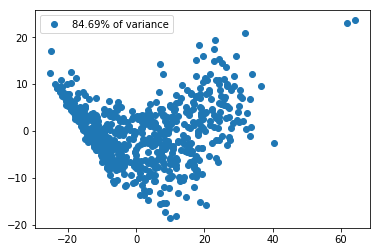

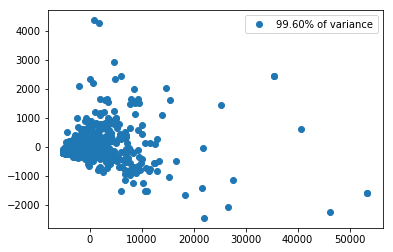

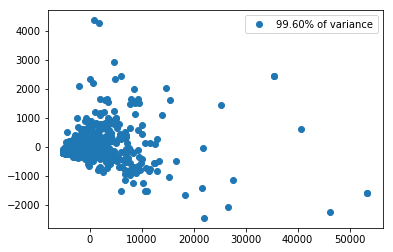

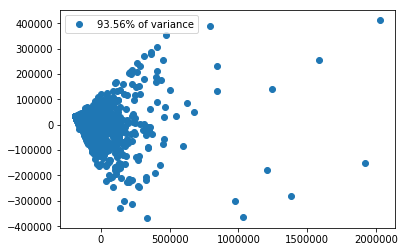

In [44]:
for feature_cols in [TRC_HORR, CATEGORIE_TITRE, TRC_HORR + CATEGORIE_TITRE]:
    X = data.loc[:, feature_cols]
    plot_pca(X)
    
data_1 = data.copy()
for hour in TRC_HORR:
    data_1[hour] = data_1[hour] * data_1.TOTAL
X = data_1.loc[:, feature_cols]
plot_pca(X)

### Clustering

Dans cette partie nous allons appliquer les algorithmes de clustering sur les entrées TRANC_HORR, CATEGORIE_TITRE et un mélange des deux.

In [45]:
# Chaîne algorithmique de clustering
def clustering_result(X, cluster, n_clusters=None, plot=True):
    X_pca = pca_transform(X)
    Y = cluster(n_clusters=n_clusters).fit(X_pca).labels_ if n_clusters else cluster().fit(X_pca).labels_
    
    if plot :
        df = pd.DataFrame({'X1': X_pca[:, 0], 'X2': X_pca[:, 1], 'Y': Y})

        for i in [0, 1, 2]:
            to_plot = df[df.Y == i]
            plt.plot(to_plot.X1, to_plot.X2, 'o', label=i)
            plt.legend()
        plt.show()
    
    return Y

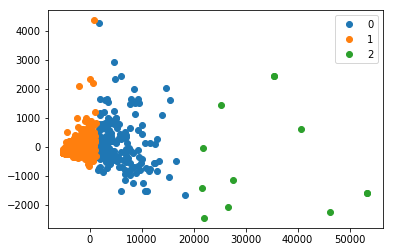

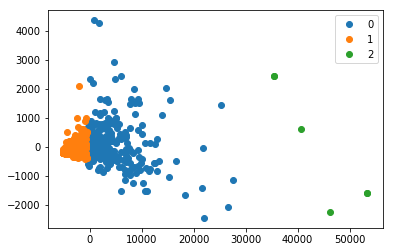

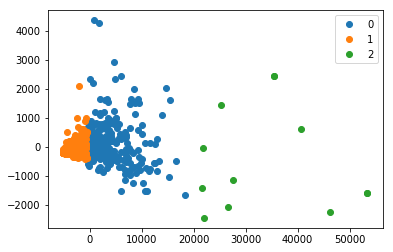

In [46]:
# Clustering pour CATEGORIE_TITRE en entrée
feature_cols = CATEGORIE_TITRE

for cluster in [KMeans, AgglomerativeClustering, Birch]:
    X = data.loc[:, feature_cols]
    clustering_result(X, cluster, 3)

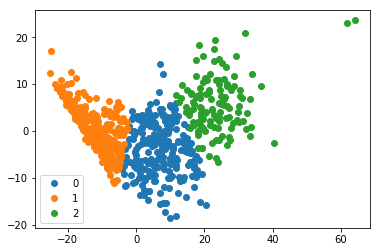

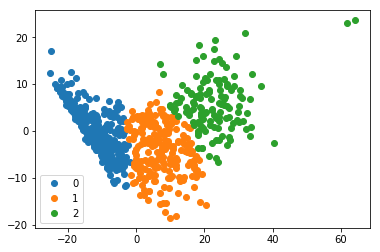

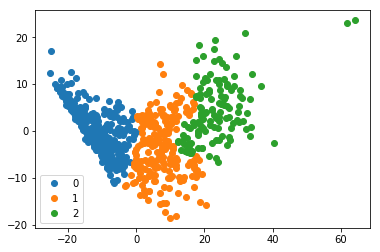

In [47]:
# Clustering pour TRC_HORR en entrée
feature_cols = TRC_HORR

for cluster in [KMeans, AgglomerativeClustering, Birch]:
    X = data.loc[:, feature_cols]
    clustering_result(X, cluster, 3)

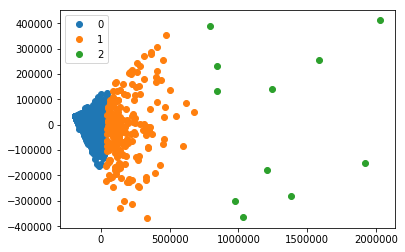

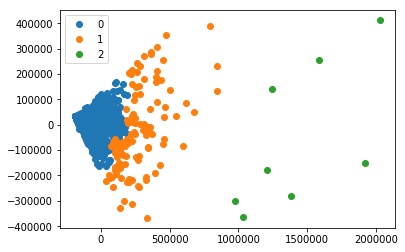

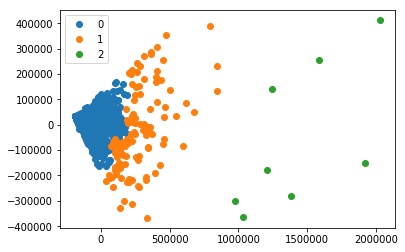

In [48]:
# Clustering pour le mélange des deux
feature_cols = TRC_HORR

for cluster in [KMeans, AgglomerativeClustering, Birch]:
    X = data_1.loc[:, feature_cols]
    clustering_result(X, cluster, 3)

## Conclusion et visualisation finale

### Visualisation

Certains des algorithmes ci-dessus donnes des résultats très similaires. Nous avons choisi de nous attarder sur l'aglorithme 'Birch' appliqué aux différentes catégories de titres seulement. Voici la carte obtenue avec la visualisation des différents clusters.

In [49]:
feature_cols = CATEGORIE_TITRE
X = data.loc[:, feature_cols]
data['cluster'] = clustering_result(X, Birch, 3, False)
draw_map(data)

c:\program files (x86)\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Conclusion

Nous pouvons voir d'après les résultats ci-dessus que nous avons réussi à clusteriser les différentes stations du réseau ferré suivant leur importance. En vert on retrouve les stations étant au centre du réseau et qui sont des gros pôles d'intérêts comme les gares ou la Défense, en bleu ce sont les stations couramment utilisées, et en rouge ce sont les stations peu fréquentées.

Si l'on regarde la répartition de station rouge et bleu sur la branche Sud du RER B, on se rend compte que les stations en rouge sont les stations qui ne sont pas déservies par tous les RER. En reportant ce principe sur le métro, on pourrait alors penser à un métro qui ne s'arrête pas à toutes les stations sur tous ses passages.